# <font color = Orange> Project -  Alternus Vera </font>



### <font color = Brown>Team: code-monkeys </font>


### <font color = Brown>Name: Puja Kawale (012506156)</font>

### <font color = Brown> GitHub: https://github.com/pujakb/ML/tree/master/News_Classifier</font>

### <font color = green>Factor : Sensationalism </font>
<br>
### <font color = green>Domain ranking achived using cosine similarity </font>
<br>


## <font color = Orange> Importing Libraries </font>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
import nltk
import nltk.corpus 
from nltk.tokenize import word_tokenize
import csv

## <font color = Orange> Loading the Data </font>

In [2]:
training = pd.read_csv('C://PUJAMS//machinelearning//csvfiles//liar_dataset//train.tsv',sep='\t')
testing = pd.read_csv('C://PUJAMS//machinelearning//csvfiles//liar_dataset//test.tsv',sep='\t')
validation = pd.read_csv('C://PUJAMS//machinelearning//csvfiles//liar_dataset//valid.tsv',sep='\t')
vocabulary = pd.read_csv (r'C:\PUJAMS\machinelearning\csvfiles\liar_dataset\sensation_dictionary.csv')

In [3]:
columns = ['id', 'label', 'statement', 'subjects', 'speaker',
         'speaker_job', 'state', 'party', 'barely_true_counts',
         'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts',
         'context']
training.columns = columns
testing.columns = columns
validation.columns = columns
training.head(5)

,id,label,statement,subjects,speaker,speaker_job,state,party,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context
0,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
1,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
2,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
3,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN
4,12465.json,true,The Chicago Bears have had more starting quart...,education,robin-vos,Wisconsin Assembly speaker,Wisconsin,republican,0.0,3.0,2.0,5.0,1.0,a an online opinion-piece


In [4]:
#data integrity check (missing label values)
#none of the datasets contains missing values therefore no cleaning required
def data_qualityCheck():
    
    print("Checking data qualitites...")
    training.isnull().sum()
    training.info()
        
    print("check finished.")

    #below datasets were also used
    testing.isnull().sum()
    testing.info()

    validation.isnull().sum()
    validation.info()

data_qualityCheck()

Checking data qualitites...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10239 entries, 0 to 10238
Data columns (total 14 columns):
id                      10239 non-null object
label                   10239 non-null object
statement               10239 non-null object
subjects                10237 non-null object
speaker                 10237 non-null object
speaker_job             7342 non-null object
state                   8031 non-null object
party                   10237 non-null object
barely_true_counts      10237 non-null float64
false_counts            10237 non-null float64
half_true_counts        10237 non-null float64
mostly_true_counts      10237 non-null float64
pants_on_fire_counts    10237 non-null float64
context                 10137 non-null object
dtypes: float64(5), object(9)
memory usage: 1.1+ MB
check finished.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1266 entries, 0 to 1265
Data columns (total 14 columns):
id                      1266 non-null obj

## <font color = Orange>Observing the data </font>

In [5]:
#data observation
def data_obs():
    print("training dataset size:")
    print(training.shape)
    print(training.head(10))

    #below dataset were used for testing and validation purposes
    print(training.shape)
    print(training.head(10))
    
    print(validation.shape)
    print(validation.head(10))
    
data_obs()

training dataset size:
(10239, 14)
           id        label                                          statement  \
0  10540.json    half-true  When did the decline of coal start? It started...   
1    324.json  mostly-true  Hillary Clinton agrees with John McCain "by vo...   
2   1123.json        false  Health care reform legislation is likely to ma...   
3   9028.json    half-true  The economic turnaround started at the end of ...   
4  12465.json         true  The Chicago Bears have had more starting quart...   
5   2342.json  barely-true  Jim Dunnam has not lived in the district he re...   
6    153.json    half-true  I'm the only person on this stage who has work...   
7   5602.json    half-true  However, it took $19.5 million in Oregon Lotte...   
8   9741.json  mostly-true  Says GOP primary opponents Glenn Grothman and ...   
9   7115.json  mostly-true  For the first time in history, the share of th...   

                                    subjects                 speaker  \
0

9                     0  a speech at the Democratic National Convention...  


In [6]:
training=training[['label','statement']]
training.head(5)

,label,statement
0,half-true,When did the decline of coal start? It started...
1,mostly-true,"Hillary Clinton agrees with John McCain ""by vo..."
2,false,Health care reform legislation is likely to ma...
3,half-true,The economic turnaround started at the end of ...
4,true,The Chicago Bears have had more starting quart...


In [7]:
training.groupby('label').describe()

statement         \
                count unique   
label                          
barely-true      1654   1654   
false            1994   1987   
half-true        2114   2112   
mostly-true      1962   1962   
pants-fire        839    839   
true             1676   1674   

                                                                     
                                                           top freq  
label                                                                
barely-true  Even the employees union for the IRS -- the ve...    1  
false        On changing the rules for filibusters on presi...    3  
half-true    During Sherrod Browns past decade as a D.C. po...    2  
mostly-true  Says MarcoRubio voted to slash school funding ...    1  
pants-fire   The new Hartsfield-Jackson international termi...    1  
true         Six justices on the U.S. Supreme Court have be...    2

In [8]:
training.iloc[0]["statement"][:len(training.iloc[0]["statement"])]

'When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration.'

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000BE8F0B8>,
      dtype=object)

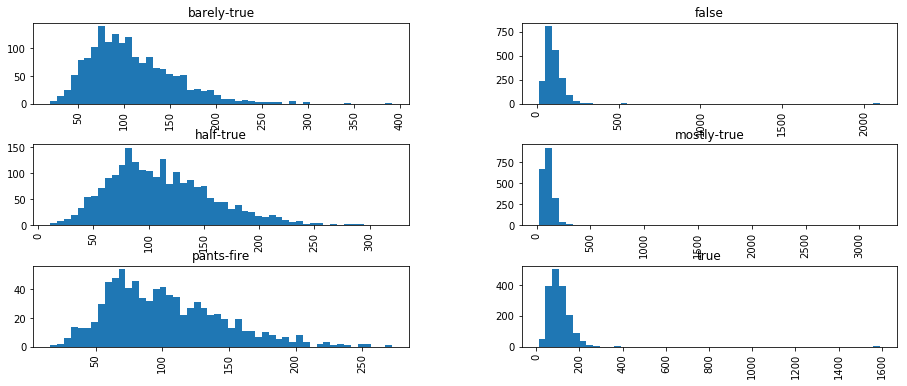

In [9]:
training['length'] = training['statement'].apply(len)
training.hist(column='length',by='label',bins=50, figsize=(15,6))

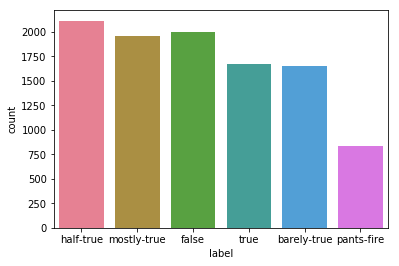

In [10]:
#distribution of classes for prediction
def create_distribution(dataFile):
    
    return sns.countplot(x='label', data=dataFile, palette='husl')
    

#by calling below we can see that training, test and valid data seems to be failry evenly distributed between the classes
create_distribution(training)

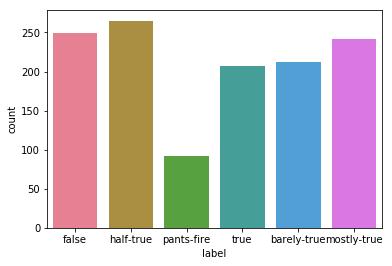

In [11]:
create_distribution(testing)

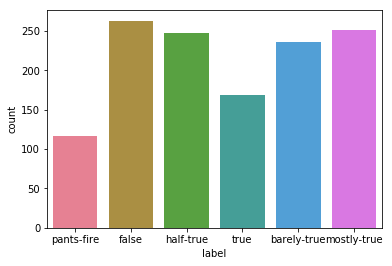

In [12]:
create_distribution(validation)

In [13]:
training.label.unique()

array(['half-true', 'mostly-true', 'false', 'true', 'barely-true',
       'pants-fire'], dtype=object)

In [14]:
# This is in case we want to conduct binary classification
# Our focus is to develop a multi-classification model

# train_news['label']=np.where(train_news['label']=='half-true','true',train_news['label'])
# train_news['label']=np.where(train_news['label']=='mostly-true','true',train_news['label'])
# train_news['label']=np.where(train_news['label']=='barely-true','false',train_news['label'])
# train_news['label']=np.where(train_news['label']=='pants-fire','false',train_news['label'])
# train_news['label']=np.where(train_news['label']=='TRUE','true',train_news['label'])
# train_news['label']=np.where(train_news['label']=='FALSE','false',train_news['label'])

# plt.title('statement count Vs label')
# train_news.groupby(['label']).size().plot(kind='bar', color='blue')
# plt.xlabel('count')
# plt.show()

# <font color = Orange> Factor: Sensationalism </font>
    

Added a dictionary to filter the document thats contain the words that make the news statement sensation ...that go viral and become breaking.

In [15]:
my_dictionary = "Assassination Attack Domestic security Law enforcement Disaster National preparedness Response Recovery Emergency response First responder Militia Shooting Evacuation Hostage Explosion Organized crime Gangs National security State of emergency Security breach Threat Standoff Lockdown Bomb Riot Emergency Landing Incident Suspicious Nuclear threat Hazardous Infection Outbreak Contamination Terror Epidemic Critical Infrastructure National infrastructure Transportation security Grid Outage Disruption Violence Drug cartel Narcotics Shootout Trafficking Kidnap Illegal Smuggling  Al Qaeda Terror attack Weapon Improvised explosive Suicide bomber Suicide attack Hurricane Tornado Tsunami Earthquake Tremor Flood Storm Extreme weather Forest fire Ice Stranded Wildfire Avalanche Blizzard Lightening Emergency Broadcast System Cyber Security DDOS Denial of service Malware Phishing attack terror believe support ISIS absolutely promise society FBI declare war islam recession price stock market lottery sanction  ban signed climate change global warming killed gun fire nuclear" 

my_dictionary

'Assassination Attack Domestic security Law enforcement Disaster National preparedness Response Recovery Emergency response First responder Militia Shooting Evacuation Hostage Explosion Organized crime Gangs National security State of emergency Security breach Threat Standoff Lockdown Bomb Riot Emergency Landing Incident Suspicious Nuclear threat Hazardous Infection Outbreak Contamination Terror Epidemic Critical Infrastructure National infrastructure Transportation security Grid Outage Disruption Violence Drug cartel Narcotics Shootout Trafficking Kidnap Illegal Smuggling  Al Qaeda Terror attack Weapon Improvised explosive Suicide bomber Suicide attack Hurricane Tornado Tsunami Earthquake Tremor Flood Storm Extreme weather Forest fire Ice Stranded Wildfire Avalanche Blizzard Lightening Emergency Broadcast System Cyber Security DDOS Denial of service Malware Phishing attack terror believe support ISIS absolutely promise society FBI declare war islam recession price stock market lottery

In [16]:
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize 
nltk.download('punkt')

def TextCleansing(txt):
    rem = re.sub('[^a-zA-Z]', ' ', txt)
    rem = rem.lower()
    rem = rem.split()
    ps = PorterStemmer()
    rem = [ps.stem(word) for word in rem if not word in set(stopwords.words('english'))]
    rem = ' '.join(rem)
    return rem

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PB\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PB\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [17]:
stop_words=set(stopwords.words('english'))
print(stop_words)

{'after', 'how', 'shouldn', "you're", 'had', 'more', 'didn', 'won', 'he', 'out', 'there', 'i', 't', 'myself', "you'll", 'and', 'was', 'who', 'if', 'needn', 're', 'be', 'while', 'that', 'no', 'me', 'aren', "aren't", 'does', 'ma', 'himself', "shan't", 'until', 'couldn', 'why', 'your', 'it', 'having', 'did', 'further', 'theirs', 'from', 'his', 'very', 'my', 'then', 'yours', 'am', 'here', 'most', 'all', 'herself', 'again', "shouldn't", 'wouldn', 'of', 'because', 'on', 'hadn', 'mightn', 'not', 'over', 'nor', 'at', 'yourselves', "that'll", "couldn't", 'have', 'by', 'ourselves', "wasn't", 'the', 'were', 'm', 'each', "weren't", "you've", "it's", 'them', 'don', "needn't", 'hers', 'some', 'him', 'between', 'such', "wouldn't", 'about', 've', 'just', "won't", 'above', 'mustn', 'before', 'been', 'under', 'whom', 'those', 'against', "hasn't", 'being', 'too', 'few', 'ours', 'to', "haven't", 'which', 'own', 'weren', 'its', 'as', 'has', 'our', 'she', 'is', 'can', 'ain', 'now', 'this', 'up', "isn't", 'd

In [18]:
TextCleansing(my_dictionary)
my_dictionary

'Assassination Attack Domestic security Law enforcement Disaster National preparedness Response Recovery Emergency response First responder Militia Shooting Evacuation Hostage Explosion Organized crime Gangs National security State of emergency Security breach Threat Standoff Lockdown Bomb Riot Emergency Landing Incident Suspicious Nuclear threat Hazardous Infection Outbreak Contamination Terror Epidemic Critical Infrastructure National infrastructure Transportation security Grid Outage Disruption Violence Drug cartel Narcotics Shootout Trafficking Kidnap Illegal Smuggling  Al Qaeda Terror attack Weapon Improvised explosive Suicide bomber Suicide attack Hurricane Tornado Tsunami Earthquake Tremor Flood Storm Extreme weather Forest fire Ice Stranded Wildfire Avalanche Blizzard Lightening Emergency Broadcast System Cyber Security DDOS Denial of service Malware Phishing attack terror believe support ISIS absolutely promise society FBI declare war islam recession price stock market lottery

## <font color = Orange>**Distillation:** </font>
#### <font color = Brown> Tokenization: Split the text into sentences, Sentences into words, Lowercase the words, remove punctuation.
#### <font color = Brown> Words that have fewer than 3 characters are removed.
#### <font color = Brown> stopwords are removed.
#### <font color = Brown> lemmatization — words in third person are changed to first person and verbs in past and future tenses are changed into present.
#### <font color = Brown> Stemming — words are reduced to their root form.</font>

In [19]:
def cleaning(raw_news):
    import nltk    
    news = re.sub("[^a-zA-Z]", " ", raw_news)    
    news =  news.lower()     
    news_words = nltk.word_tokenize( news)        
    stops = set(nltk.corpus.stopwords.words("english"))       
    words = [w for w in  news_words  if not w in stops]        
    stems = [nltk.stem.SnowballStemmer('english').stem(w) for w in words]     
    return " ".join(stems)

In [20]:
import re
training['statement'] = training["statement"].apply(cleaning) 
testing['statement'] = testing["statement"].apply(cleaning)
print(len(training), "statements")
print(len(testing), "statements")

10239 statements
1266 statements


## <font color = orange>Word Cloud Visualization </font>

Google says a word cloud is “an image composed of words used in a particular text or subject, in which the size of each word indicates its frequency or importance.”
So, the more often a specific words appears in your text, the bigger and bolder it appears in your word cloud.

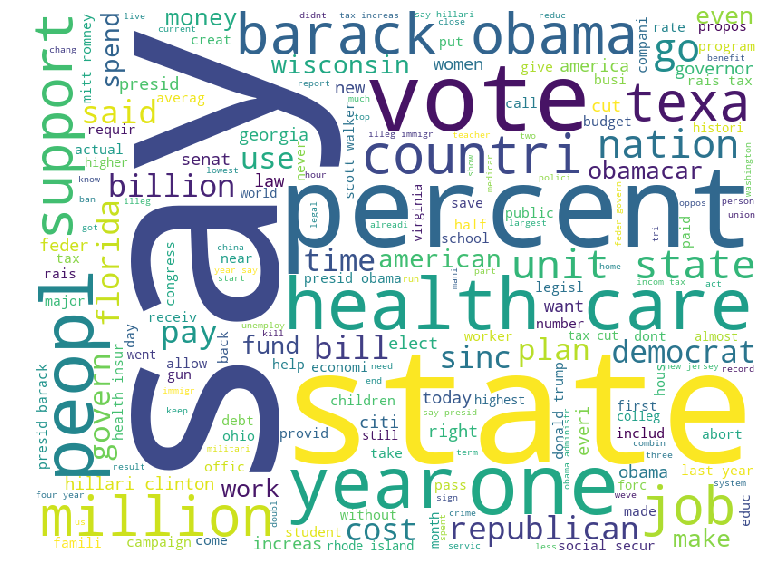

In [21]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

%matplotlib inline

def cloud(data,backgroundcolor = 'white', width = 800, height = 600):
    wordcloud = WordCloud(stopwords = STOPWORDS, background_color = backgroundcolor,
                         width = width, height = height).generate(data)
    plt.figure(figsize = (15, 10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    
cloud(' '.join(training['statement']))

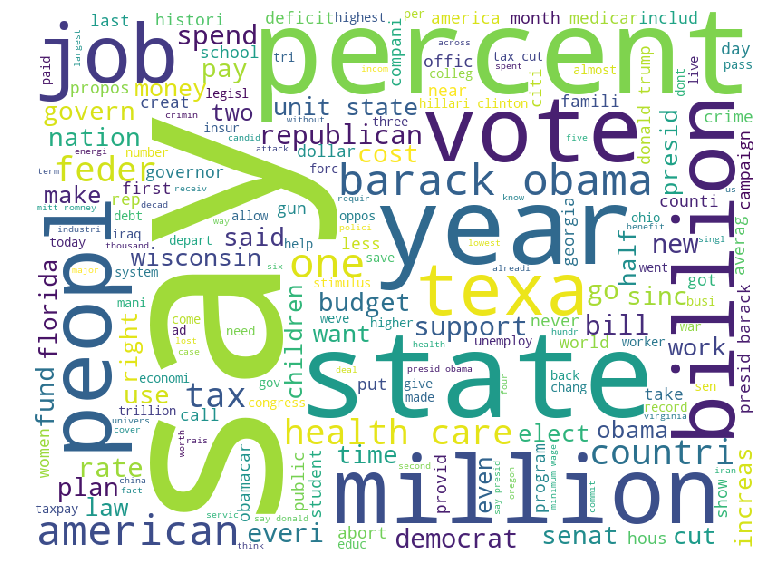

In [22]:
cloud(' '.join(testing['statement']))

In [23]:
training.head(3)

,label,statement,length
0,half-true,declin coal start start natur gas took start b...,141
1,mostly-true,hillari clinton agre john mccain vote give geo...,105
2,false,health care reform legisl like mandat free sex...,78


## Calculating <font color = Orange>Cosine Similary </font>of all the news headlines with the Sensationalism vocabulary. This would help differentiating the Breaking news from rest of the news

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
import nltk
import nltk.corpus 
from nltk.tokenize import word_tokenize
import csv

## <font color = orange>Tokenization </font>
Tokenization is the process of dividing text into a set of meaningful pieces. These pieces are called tokens. For example, we can divide a chunk of text into words, or we can divide it into sentences

In [25]:
corpus = []
import gensim
from nltk.tokenize import word_tokenize

for text in training['statement']:
    corpus.append(text)

C:\Users\PB\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


Below if the corpus of all tokens inside the statement column

In [26]:
print(corpus)

['declin coal start start natur gas took start begin presid georg w bush administr', 'hillari clinton agre john mccain vote give georg bush benefit doubt iran', 'health care reform legisl like mandat free sex chang surgeri', 'econom turnaround start end term', 'chicago bear start quarterback last year total number tenur uw faculti fire last two decad', 'jim dunnam live district repres year', 'person stage work activ last year pass along russ feingold toughest ethic reform sinc waterg', 'howev took million oregon lotteri fund port newport eventu land new noaa marin oper center pacif', 'say gop primari oppon glenn grothman joe leibham cast compromis vote cost million higher electr cost', 'first time histori share nation popular vote margin smaller latino vote margin', 'sinc near million american slip middl class poverti', 'mitt romney governor massachusett didnt slow rate growth govern actual cut', 'economi bled billion due govern shutdown', 'afford care act alreadi sens waiv otherwis su

Below is the copus of all the tokens inside the statement coloumn and sensationalism dictionary

In [27]:
corpus.append(my_dictionary)
print(corpus)

['declin coal start start natur gas took start begin presid georg w bush administr', 'hillari clinton agre john mccain vote give georg bush benefit doubt iran', 'health care reform legisl like mandat free sex chang surgeri', 'econom turnaround start end term', 'chicago bear start quarterback last year total number tenur uw faculti fire last two decad', 'jim dunnam live district repres year', 'person stage work activ last year pass along russ feingold toughest ethic reform sinc waterg', 'howev took million oregon lotteri fund port newport eventu land new noaa marin oper center pacif', 'say gop primari oppon glenn grothman joe leibham cast compromis vote cost million higher electr cost', 'first time histori share nation popular vote margin smaller latino vote margin', 'sinc near million american slip middl class poverti', 'mitt romney governor massachusett didnt slow rate growth govern actual cut', 'economi bled billion due govern shutdown', 'afford care act alreadi sens waiv otherwis su

## <font color = orange>TFidf Vectorization</font>
Tf-idf stands for term frequency-inverse document frequency.This weight is a statistical measure used to evaluate how important a word is to a document in a collection or corpus
Convert a collection of raw documents to a matrix of TF-IDF features. Equivalent to CountVectorizer followed by TfidfTransformer.

TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document).

IDF(t) = log_e(Total number of documents / Number of documents with term t in it).

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
vectorizer

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [29]:
X = vectorizer.fit_transform(corpus)
X
print(X)

  (0, 1693)	0.2738374304455053
  (0, 1257)	0.2754891097392278
  (0, 6465)	0.6784639163161784
  (0, 4518)	0.2754891097392278
  (0, 2722)	0.22476016759484116
  (0, 6953)	0.20271749904885128
  (0, 602)	0.26785505749732624
  (0, 5287)	0.14821230010119513
  (0, 2761)	0.2234140694522201
  (0, 915)	0.19695752559571353
  (0, 91)	0.19718120693930158
  (1, 2761)	0.2894702848969141
  (1, 915)	0.2551914084308619
  (1, 3128)	0.24744024394102065
  (1, 1238)	0.23217606754896308
  (1, 141)	0.3435818448790626
  (1, 3593)	0.26505747695182685
  (1, 4187)	0.27304360933647137
  (1, 7375)	0.19195158890134262
  (1, 2793)	0.271822098953158
  (1, 628)	0.28778466209962905
  (1, 1982)	0.43367695433807024
  (1, 3488)	0.30243471579471704
  (2, 3058)	0.21594498891537106
  (2, 1004)	0.22385201282014103
  :	:
  (10239, 7036)	0.07759946657777618
  (10239, 2355)	0.07759946657777618
  (10239, 6542)	0.07759946657777618
  (10239, 7543)	0.07759946657777618
  (10239, 462)	0.07759946657777618
  (10239, 714)	0.077599466577776

In [30]:
training['statement'][1628]

'there money plan parenthood bill would keep govern open'

In [31]:
vectorizer.vocabulary_

{'declin': 1693,
 'coal': 1257,
 'start': 6465,
 'natur': 4518,
 'gas': 2722,
 'took': 6953,
 'begin': 602,
 'presid': 5287,
 'georg': 2761,
 'bush': 915,
 'administr': 91,
 'hillari': 3128,
 'clinton': 1238,
 'agre': 141,
 'john': 3593,
 'mccain': 4187,
 'vote': 7375,
 'give': 2793,
 'benefit': 628,
 'doubt': 1982,
 'iran': 3488,
 'health': 3058,
 'care': 1004,
 'reform': 5591,
 'legisl': 3873,
 'like': 3940,
 'mandat': 4096,
 'free': 2633,
 'sex': 6102,
 'chang': 1111,
 'surgeri': 6666,
 'econom': 2086,
 'turnaround': 7090,
 'end': 2178,
 'term': 6814,
 'chicago': 1152,
 'bear': 583,
 'quarterback': 5431,
 'last': 3817,
 'year': 7648,
 'total': 6969,
 'number': 4657,
 'tenur': 6813,
 'uw': 7278,
 'faculti': 2372,
 'fire': 2503,
 'two': 7105,
 'decad': 1680,
 'jim': 3585,
 'dunnam': 2048,
 'live': 3969,
 'district': 1920,
 'repres': 5662,
 'person': 5053,
 'stage': 6443,
 'work': 7603,
 'activ': 71,
 'pass': 4948,
 'along': 211,
 'russ': 5856,
 'feingold': 2443,
 'toughest': 6974,
 'e

In [32]:
features = vectorizer.get_feature_names()
print(features[1111])

chang


In [33]:
X.shape

(10240, 7697)

In [34]:
X.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [35]:
from scipy import spatial

Cosine similarity

In [36]:
cos_statement1 = 1 - spatial.distance.cosine(X[7356].toarray(), X[10238].toarray())
cos_statement1

0.12380552970475689

## <font color = Brown> Below we get all the news headlines along with its similarity score with sensational words dicationary </font>

we can easily interpret that higher the similarity score, hiher are the chances of the news to be sensational, viral, breaking !! <br>
reference: https://www.oreilly.com/learning/how-do-i-compare-document-similarity-using-python

In [37]:
for i in range(10238):
    cos_statement1 = 1 - spatial.distance.cosine(X[i].toarray(), X[10238].toarray())
    print(training['statement'][i], "=>",cos_statement1)

declin coal start start natur gas took start begin presid georg w bush administr => 0.0
hillari clinton agre john mccain vote give georg bush benefit doubt iran => 0.0
health care reform legisl like mandat free sex chang surgeri => 0.04917822150565909
econom turnaround start end term => 0.0
chicago bear start quarterback last year total number tenur uw faculti fire last two decad => 0.0
jim dunnam live district repres year => 0.0
person stage work activ last year pass along russ feingold toughest ethic reform sinc waterg => 0.0
howev took million oregon lotteri fund port newport eventu land new noaa marin oper center pacif => 0.0
say gop primari oppon glenn grothman joe leibham cast compromis vote cost million higher electr cost => 0.0
first time histori share nation popular vote margin smaller latino vote margin => 0.0
sinc near million american slip middl class poverti => 0.0
mitt romney governor massachusett didnt slow rate growth govern actual cut => 0.0
economi bled billion due go

militari recruit went harvard everi singl day throughout time kagan => 0.0
say rick perri plan texa cut fund public school => 0.0
say david perdu want abolish u depart educ would cost georgia school billion year elimin million student loan => 0.04979793498219043
paul ryan budget propos would privat medicar => 0.0
high school student arrest campus twice like graduat four time less like graduat theyv appear court => 0.0687313915811163
unit state imprison nation world => 0.0
say marco rubio one open border => 0.0
year feder spend educ grown percent test score remain flat => 0.0
say cut medicar affect peopl alreadi paid paid => 0.0
david alameel give thousand dollar support republican parti candid includ john cornyn greg abbott => 0.0
american healthcar system burn percent nation gdp nobodi els close => 0.0
provid port mile closer europ eastern port => 0.0
say need photo id purchas sudaf texa => 0.0
twenti percent hous portland pearl district afford => 0.0
say allow payrol tax holiday expi

even republican congressmen said give us money dont know would even put addit border patrol agent => 0.04603480431253937
today first time fifteen year master lock union plant milwauke run full capac => 0.0
tom reed actual vote everi singl trade deal ever come form => 0.0
isi camp mile texa mexican author confirm => 0.0
new feder project estim health care overhaul cost trillion year well billion democrat origin claim => 0.0
say new jersey rep donald payn frank pallon socialist open serv u congress => 0.0
unemploy rate may high percent => 0.0
common core feder govern fingerprint thing => 0.0
social secur inde ponzi scheme => 0.0
say scott walker brag lot independ agenc investig polic shoot cours didnt fund => 0.0
arizona law make state crime someth alreadi feder crime => 0.0
countri found congress exact attitud sanctiti christma celebr eleven today yeah open => 0.0
miami dade counti spend school system million everi year educ recent immigr => 0.0
omnibus bill billion earmark => 0.0
trump

sinc unit state began negoti iran that probabl first year half iran advanc nuclear program last decad => 0.0
say ohio x center use great plant thousand peopl work left job move oversea => 0.0
weve got nation guard troop request that front presid year respons => 0.0
new law doctor perform drug induc abort could charg women dont return follow care => 0.0
say veteran disabl claim backlog doubl obama first term => 0.15019314525213545
minimum percent view child pornographi end molest children result => 0.0
differ way governor mccrori rais tax middl incom famili => 0.0
romney advis admit romneycar blueprint obamacar => 0.0
say texa voter ask act novemb propos constitut amend affect properti tax => 0.0
hard get peopl portland vote yes ballot measur especi there opposit => 0.0
nytim sent letter subscrib apolog bad coverag => 0.0
busi oregon shrink back busi result law => 0.0
say straight year major hurrican strike land unit state bore hole right whole climat chang argument => 0.0
spend money h

say danni tarkanian nra frate => 0.0
unit state stop plan build missil defens shield eastern europ gift russia => 0.0
say steve kagen promis us job vote billion stimulus cost anoth job lost => 0.0
delay health care mandat busi => 0.0
georgia civil forfeitur law among worst countri worst south => 0.0
gas price gone percent sinc obama becam presid highest gas price increas sinc carter => 0.0
romney would turn medicar voucher program => 0.0
report came continu presid obama polici look percent unemploy next year fourth quarter => 0.0
forti six state line item veto governor => 0.0
way feder govern spend florida reject high speed rail money => 0.0
accord barack obama newest unconstitut enact law health care profession requir violat hipaa privaci law submit medic data govern use justif gun confisc => 0.0
mike huckabe rais tax dog groomer => 0.0
say jeb bush happen major republican voter areon give legal status illeg immigr => 0.0
massachusett less percent kid uninsur gov perri million kid uni

john mccain vote bush tax cut time => 0.0
averag student debt come univers wisconsin madison someth like dollar => 0.05033390982085606
due flaw outer continent shelf deep water royalti relief act numer oil compani drill gulf mexico feder land pay royalti feder govern => 0.0
say hillari clinton vote virtual everi trade agreement cost worker countri million job => 0.0
say rep john katko promis wouldnt vote defund plan parenthood sinc hes offic hes done four time => 0.0
say los angel clipper owner donald sterl democrat => 0.0
fact special assist johnkasich offic make three time averag oh firefight => 0.0
obama wife said goal life put black communiti first foremost => 0.06634286018595592
money toward ebola vaccin basic cut half cut come congression sequest => 0.0
say state sen randi hopper r fond du lac unlik typic taxpay didnt pay tax => 0.0
new school test standard consum approxim twenti day test elementari middl high school student => 0.0
obama vote tax subsidi giveway slow oil compani 

year redistrict open interact transpar redistrict process tennesse histori => 0.0
econom sanction iran suffer percent inflat percent unemploy => 0.0
say wisconsin governor end welfar => 0.0
th congression district electr generat come coal => 0.0
folk washington alreadi forc buy govern health care => 0.0
say presid barack obama first presid weve ever think choos law enforc law ignor => 0.0
percent illeg immigr peopl physic cross southern border northern border visa overstay => 0.0
charli crist work acorn give felon vote right => 0.0
support gay marriag => 0.0
year ad averag job per month major privat sector stark contrast bush administr record lose averag near job per month last three month => 0.0
republican congress refus list singl tax loophol will close => 0.0
say hillari clinton iran nuclear deal line pocket world number one state sponsor terror money => 0.0
obama think nation anthem like teach world sing => 0.04880922533303855
right america trillion student debt that credit card de

today two vietnam side side north south exchang work => 0.0
data system goe along common core design collect data point child includ person identifi data => 0.0
alison alter got f attend austin park board member remov unanim vote austin citi council => 0.0
say got lobbi woman late stage cancer vaccin texa girl virus caus cervic cancer => 0.0
florida shell money drug test save deni welfar benefit peopl test posit drug => 0.0
illeg immigr lower year => 0.0
ive got percent career vote record congress bill nelson percent vote record => 0.0
secretari state high approv rate => 0.0
kesha roger democrat => 0.0
say hous republican spent million vote repeal obamacar => 0.0
democrat pois caus largest tax increas u histori => 0.0
say mayor cori booker newark seen violent crime five year row murder five year row => 0.0
seventi ohio counti percent resid elig emerg food => 0.0
americanschool segreg => 0.0
filibust => 0.0
presid obama inact caus three week go even approv governor plan protect marsh =>

sinc took offic new privat sector job creat georgia near come past month => 0.0
go difficult us long spend million day war never author => 0.0
today selma ala poverti rate rough nine time white => 0.0
say presid obama propos pinprick strike militari intervent syria => 0.0
say polit prison cuba => 0.0
say illinoi democrat david gill would end medicar => 0.0
first said would leav residu forc iraq say => 0.0
say last year graduat rate combin six district footprint jump percent => 0.0
presid obama director nation intellig admir blair put way high valu inform came interrog method use provid deeper understand al qaida organ attack countri => 0.05793520539664643
donald trump ask florida casino gambl said => 0.0
milwauke polic use dead forc rate among lowest countri => 0.0
sen edward ran univers health care glad => 0.0
say barbara buono vote rais pay percent => 0.0
say texa uninsur peopl state million => 0.0
ill run career politician => 0.0
say multnomah counti librari open hour per week lowes

tell david cicillin percent carbon emiss want get rid caus natur => 0.07333169554803232
sen barbara boxer vote immigr reform permit hispan immigr peopl come legal work => 0.0
senat obama liber vote record unit state senat => 0.0
say mari burk madison school district school district left state ignor act law school year => 0.0
growth sector weve last two year america govern growth => 0.0
rais minimum wage actual help half work full time averag worker year old => 0.0
fifti percent graduat class year smoke marijuana done illeg drug => 0.0
taxpay pay fortun use air forc one campaign trail presid barack obama hillari clinton => 0.0
note mani observ includ bill clinton former secretari labor plan anybodi reduc cost => 0.0
public option fund public money fund privat insur premium => 0.0
thirti eight state georgia includ appoint rather elect state school superintend => 0.0
come nobodi stop train => 0.0
averag u militari work dog save live servicemen women span career => 0.0
onlin chang address 

debat among constitut scholar whether first amend continu protect faith leader forc perform marriag religi belief => 0.0
last year american oil product reach highest level sinc => 0.0
head fbi told congress vet syrian refuge => 0.0
eighti five percent fund collect counti redistribut elsewher spent counti collect => 0.0
weve rebuilt china => 0.0
say ratio ceo pay averag worker pay u => 0.0
year obama administr releas crimin illeg alien releas murder peopl homicid convict illeg => 0.0
women texa attempt self induc abort past year alon => 0.0
say missouri famili earn power less today turn centuri => 0.0
platform republican parti say deport everybodi hell => 0.0
say marcorubio vote slash school fund billion dollar would elimin depart educ => 0.05760213221343924
percent noncitizen regist vote => 0.0
redskin use histor term respect => 0.0
say three legisl session propos open pre kindergarten texa year old never got heard vote committe => 0.0
seven school district lowest graduat rate african 

say washington c sen richard burr took million special interest went cash vote cut tax rais tax work folk => 0.0
say oregon rank rd educ => 0.0
say virginia biggest state major leagu sport team => 0.0
scientif evid co pollut higher co concentr actual help ecosystem support plant anim life => 0.0
ever boycott encourag organ => 0.14256836889875235
turn texa billion budget shortfal cant afford new scienc textbook => 0.0
say tax doubl rick perri offic => 0.0
mike martinez cut deal prosecutor avoid face possibl jail time stuck us legal bill => 0.0
michell nunn spent childhood perri ga => 0.0
whether judg allow place children gay coupl wish adopt => 0.0
total ad near privat sector job new jersey sinc took offic januari 
joe straus receiv percent rate naral nation abort reproduct right action leagu => 0.0
governor tuition skyrocket stop cap froze colleg tuition => 0.0
dekalb counti cut money general fund budget local govern atlanta metro region => 0.0
say gov scott walker sign abort sex educ 

far differ pictur prior eight year saw increas tax fee => 0.0
mexico receiv approxim billion year remitt mexican nation work unit state major amount come illeg alien => 0.0
there big chunk countri think soft wall street => 0.0
congression budget offic nonpartisan offic analysi said pass comprehens immigr reform reduc feder deficit billion next decad => 0.0
barack obama oppos bill would save gianna jessen life => 0.0
former feder reserv chairman alan greenspan justifi increas spend cut tax say realli need pay debt => 0.06912057799077886
dekalb counti recogn recent year one best sheriff depart nation => 0.05779897728441319
say joe straus co author bill would allow plan parenthood control public school sex educ => 0.0
say glenn nye vote lock step nanci pelosi percentof time => 0.0
dont think argument credibl made unit state america undertax compar competitor => 0.0
say elect propos would allow potenti hour earli vote think weve ever => 0.0
member public charg hear gov scott walker dozen m

discretionari spend increas percent two year dont includ stimulus put stimulus percent => 0.0
univers wisconsin milwauke student per faculti member tie second lowest histori sinc => 0.0
oregon health plan ration cover procedur certain circumst => 0.0
iran nuclear deal => 0.0
georgia unemploy rate exceed nation rate consecut month => 0.0
charg toll motorist use ga slate expir => 0.0
million fire fee propos st petersburg inspir gov rick scott => 0.0
startup rate hispan busi three time nation rate => 0.0
made time go gym cancel visit wound troop seem pentagon allow bring camera => 0.0
say cut tax rate five time => 0.0
bruce starr senat vote stronger ethic law greater account => 0.0
broward republican execut committe liber leagu women voter guid remov broward supervisor elect websit => 0.0
judg sotomayor said polici made u court appeal => 0.0
peopl potshoot stab strangl drive influenc kill famili => 0.0
sinc take offic januari raini day fund increas percent => 0.0
say provid mayor david ci

senat bill new method evalu teacher your also go rate parent think send questionnair survey home parent => 0.0
say presid barack obama promis work employ lower premium per famili per year health care law rais premium individu market per famili => 0.0
say newt gingrich respons gridlock polit washington => 0.0
twenti seven state pharmaceut compani rais campaign dollar drug price control measur state ballot measur rais date combin => 0.0
part effort rein protest republican wisconsin bolt window insid capitol shut => 0.0
obama say clinton suggest connect al qaida iraqi govern => 0.0
say comprehens immigr reform add billion economi => 0.0
ronald reagan rais tax billion dollar first year governor california => 0.0
busi creat job everi singl month sinc obamacar becam law => 0.0
say berni sander vote regim chang respect libya => 0.0
ask mani time ronald reagan attend fundrais ran elect answer eight time say mani time barack obama attend fundrais answer time => 0.0
democrat fail flip wisconsin 

debat last week politifact came said everyth said true => 0.0
typic marri coupl contribut medicar receiv medicar benefit lifetim => 0.0
cut crime across everi singl zone citi atlanta percent percent depend zone => 0.0
there talk congress basic confisc privat k ira plan roll social secur strengthen social secur => 0.0
half last year u colleg graduat unemploy underemploy => 0.0
opinion poll show major american major new jerseyan favor marriag equal sex coupl => 0.0
peopl lost job charli crist governor => 0.0
aig insur pension trust unit state congress => 0.0
medicaid close percent state budget biggest expenditur state => 0.0
say presid barack obama respons pend defens cut => 0.0
say oppon tammi baldwin one posit ad campaign u senat => 0.0
barack obama said would debat anywher anytim reject joint town hall meet => 0.0
campaign public option => 0.0
half driver licens issu california year gone illeg alien => 0.0
dont want get like louisiana drive daiquiri shop => 0.04746258209849774
say don

new hampshir lost job china state => 0.0
saysgov john kasich incorrect claim ohio economi th nation took offic sixth nation term econom job growth => 0.0
birmingham ala cradl civil right movement => 0.0
gov scott walker budget greater percentag general fund tax dollar go pay debt ever histori 0.0
spent taxpay charli crist polit photo op special session => 0.0
hospit rick scott columbia hca health care compani top execut said even turn away poor man left die outsid door => 0.0
list voter north carolina republican tri purg two third black democrat => 0.0
fox news air stuart scott r p tribut pictur stephen smith => 0.0
seventi percent peopl live abject poverti women => 0.0
support militari strike syria => 0.0
say hurrican sandi new york mayor michael bloomberg refus allow nation guard citi restor civil order guardsmen carri gun => 0.0
th k fund th higher educ => 0.0
here someth peopl never talk coach schiano rutger best graduat rate divis footbal program america => 0.0
your white dont kno

actual start critic war iraq obama => 0.0
health insur plan member congress differ feder employe unit state govern => 0.0
sinc elect crime rate lowest decad => 0.0
u rep john barrow plan put ir charg health care => 0.0
arizona four ballot issu tough illeg immigr forti seven percent hispan arizona vote => 0.0
everi coyot kill popul replac usual multipli => 0.0
number american kill terror last decad number american kill gun last decad => 0.0
expressli prohibit law read wholli surveil domest email traffic unit state => 0.0
book sarah palin tri ban => 0.0
say unemploy would percent peopl quit look work includ feder labor forc calcul => 0.0
say colorado congression candid morgan carrol vote allow welfar recipi use tax dollar atm strip club pot dispensari => 0.0
georgia restrict ballot access law countri elect mari n independ televis interview json fals whether feder debt limit rais feder budget barack obama presid illinoi democrat interview georg stephanopoulo json half true georg w bush go

georgia could get money school scrape gold gold dome state capitol => 0.0
ive even cut salari twice => 0.0
legislatur cut texa public school fund => 0.0
near top prescrib oxycodon unit state florida => 0.0
campaign began said weve got end starvat minimum wage rais secretari clinton said let rais => 0.0
economi ad job four year obama entir eight year georg w bush => 0.0
fix loophol gun background record check system could make commonwealth safer => 0.0
weekend terrorist attack pari white hous said couldnt happen unit state isi couldnt reach us => 0.0
american peopl overwhelm iraq war => 0.0
pension system fund level year two year point => 0.0
mayor allan fung rais tax three time => 0.0
import percent milk suppli america dairyland yet dont enough milk state meet demand cheesemak => 0.0
mitt romney gave govern health care bankrupt state massachusett => 0.0
say regard presenc classifi inform email fbi director jame comey said answer truth ive said consist told american peopl => 0.0
north c

presid obama democrat spend addict driven nation debt histor proport max nation credit card led democrat downgrad countri aaa credit rate => 0.0
republican chuck grassley john boehner john mica flip flop provid end life counsel elder => 0.0
fbi involv investig peopl rio grand valley use cocain buy vote => 0.0
say marco rubio wrote pass bipartisan legisl allow va fire neglig worker => 0.0
say romney bain capit drove kb toy bankruptci load debt => 0.0
best evid lose use marijuana teenag regular eight iq point => 0.0
florida number voter regist grown million last year compar democrat grew republican grew => 0.0
havent pass budget three year singl appropri bill brought floor year => 0.0
practic allow use coal coal ship china spew air => 0.0
deepwat testimoni said theyll creat six job => 0.0
say mark zandi wrote report critic donald trump econom propos one sen john mccain former econom advis => 0.0
percent increas violent crime state california that within last year => 0.0
marco rubio say s

hous republican pledg introduc bill reform america health care system parti fail produc legisl => 0.0
poll show american overwhelm oppos obamacar especi individu mandat => 0.0
hous deleg budget bill cut million educ => 0.0
texa teach creation evolut public school => 0.0
telecom bill could keep state corpor commiss get rate return inform electr util => 0.0
portland public school invit well paid well fed school bureaucrat administr teacher staff non needi student affluent parent student adult includ extrem adult homeless illeg alien fanat muslim terrorist drug addict street peopl enjoy cheap breakfast taxpay paid school facil amidst school children => 0.0
mccain lobbi million pork project honor conserv justic => 0.0
confront unexpect storm hit metropolitan area => 0.0
among manufactur fewer employe averag cost term regul per employe => 0.0
health care bill creat million job job almost immedi => 0.0
u rep scott rigel want gun owner feder registr system => 0.0
say pension contribut gov chr

u unemploy rate remain percent consecut month longest stretch sinc great depress => 0.0
thirti one percent school district still receiv less fund per pupil prior dramat budget cut => 0.0
fewer percent hous anyon would classifi wealthi => 0.0
ohio half provid safe legal abort shut sinc gov john kasich took offic => 0.0
say rick santorum support arlen specter conserv candid twice => 0.0
fiorina plan would mean slash social secur medicar => 0.0
say neither presid barack obama mexico presid felip calderon border see what happen citizen mexico matter citizen texa => 0.0
say nation debt greater gross domest product => 0.0
member congress specif exempt mani law pass exempt fear prosecut sexual harass healthcar reform => 0.0
ten year ago austin water util use total million gallon everi summer sinc peak day water use lower => 0.0
first said would take troop six month acknowledg would take year => 0.0
law mandat fingerprint gun purchas requir that reduc gun crime five state law => 0.0
one genera

talk gun told posit governor fact receiv endors nra => 0.0
u sen bill nelson decid vote health care law => 0.0
say morgan carrol oppos requir convict sex offend regist onlin profil make harder track onlin sex offend child predat => 0.0
say adam hasner said never accept pay increas vote rais pay four time => 0.0
one reason social secur much troubl fund stream come peopl get wage peopl get wage declin dramat => 0.0
vote got think spent averag two buck pop compar buck incumb milwauke counti execut chris abel => 0.0
two month ago presid barack obama sign bill billion zika fund feder govern still commit million help florida => 0.06964144299423936
unemploy colleg educ percent unemploy colleg educ percent => 0.0
latest job number wisconsin rank third midwest => 0.0
first profession basebal team ohio citi => 0.0
three state polit solut iraq romney => 0.0
say unlik texa missouri perfect aaa credit rate => 0.0
presid author kill u citizen fight foreign terrorist organ => 0.0
white black victim d

say joe kyrillo vote raid state pension fund billion cost new jersey taxpay still today tune near billion dollar repay money => 0.0
john mccain said even sit govern spain nato alli troop afghanistan us => 0.0
john mccain want give oil compani anoth billion tax break => 0.0
greg abbott texa four year old would forc undergo standard test => 0.0
cut state spend anybodi gop field => 0.0
sinc mr foster mayor less small busi citi st petersburg => 0.0
america pay far highest price world prescript drug => 0.0
newli elect republican senat sign pledg elimin food stamp program => 0.0
mark kirk claim nation secur expertis base militari record lie least time => 0.0
republican parti percent parti id shrink => 0.0
total war iraq say mani year would destabil middl east => 0.0
claim rep sanford bishop vote similar hous speaker nanci pelosi inaccur => 0.0
larg part florida experienc year averag rainfal  0.0
energi effici legisl sponsor u sen jeann shaheen feder bureaucrat could take local build code enf

say presid barack obama parent communist => 0.0
harvard studi find state gun law fewest gun death => 0.0
none million citi austin propos spend road project use add new lane congest roadway => 0.0
rep bob goodlatt balanc budgetamend requir balanc budget => 0.0
dan sullivan wrote bill cut alaskan decis hunt fish => 0.0
school uniform polici help school safeti help truanci => 0.0
say constitut amend would help stop unfair doubl taxat real estat => 0.0
john mccain accus barack obama let infant die => 0.0
sherrod brown vote six time rais pay => 0.0
size feder govern doubl sinc year => 0.0
latest unemploy number shown near american simpli given hope come find job => 0.0
chang georgia tax fee structur overal tax cut => 0.0
say obama want redesign american flag better offer enemi hope love => 0.0
gun homicid percent past year => 0.0
say vote disast relief full fund fema => 0.0
thirteen hundr applic rhode island sign insur obamacar => 0.0
there money social secur => 0.0
say cost massachusett ta

fail buy health insur obamacar face threat jail time => 0.0
sinc decemb florida creat new job => 0.0
peopl wash car home use approxim percent water car wash => 0.0
u court appeal fourth circuit compar health care law buy pepperoni ham pizza domino pizza hut => 0.0
choos texa hous speaker => 0.0
flunk c bar exam => 0.0
new health care law million young adult coverag => 0.0
pennsylvania lost percent manufactur job sinc harrisburg lost percent manufactur job sinc => 0.0
farouk fire => 0.0
say patrick murphi name one america least effect congressmen => 0.0
obamacar add trillion deficit nation debt => 0.0
frank hillari clinton doesnt well women => 0.0
say democrat u senat candid russ feingold vote time rais tax => 0.0
gun industri isth busi america wholli protect kind liabil => 0.0
teller paid kickback direct elder consum safe deposit riski one => 0.0
say peter defazio vote nanci pelosi percent time => 0.0
peopl town vote cut medicar spend peopl vote favor obamacar that fact => 0.0
america 

within year spend interest payment nation secur => 0.0
sequestr militari cut smallest armi sinc smallest navi sinc => 0.0
florida suprem court express author florida constitut remov question ballot propos legislatur => 0.0
david beckham soccer stadium would get special tax deal let hook million tax everi year year => 0.0
republican budget => 0.0
say ted strickland admit record job tax mix spotti => 0.0
china own trillion debt trade deficit last year quarter trillion dollar => 0.0
success cash clunker => 0.0
medicaid primari sourc health insur percent hispan children georgia => 0.0
fought republican budget end medicar know => 0.08264334289143305
intern revenu code balloon page million word complic mess seven time long bibl none good news  => 0.0
social scienc irrefut children better rais mom dad => 0.0
twelv percent garbag collect solv cleanup volum plastic bag => 0.0
look real analysi tran pacif partnership go generat better pay job stabl => 0.0
say georg washington said govern take aw

neighbor san bernardino shooter knew talk tri take countri attack => 0.0
ron johnson will hand great lake oil compani => 0.0
realli isnt kind foreign polici network support advis sen sander => 0.08136569457837317
say ovid lamontagn want elimin kindergarten => 0.0
heroin prescript opioid number one caus accident prevent death wisconsin => 0.0
know spent million studi dna bear montana => 0.06056952460436382
look near men women serv us texa suprem court half zero prior judici experi => 0.0
last month weve ad million job privat sector that far excess compar period last recess => 0.0
incid threat presid barack obama greater presid modern time => 0.0
john faso took money fossil fuel compani tri take land emin domain frack gas pipelin => 0.0
took obama six month pick famili dog cram health care reform countri throat fraction time => 0.0
mayor giuliani lawsuit kill line item veto => 0.0
barack obama preach brother keeper brother aunt live real poverti kenya => 0.0
rhode island age health insur

In [38]:
for i in range(10238):
    cos_statement1 = 1 - spatial.distance.cosine(X[i].toarray(), X[10238].toarray())
#     print([i], "=>",cos_statement1) 

# <font color = orange> Top breaking sensational news in our dataset :  </font>

In [39]:
import collections
orderedDict = collections.OrderedDict()
from collections import OrderedDict

cos_val = {}
cos_headline = []
for i in range(10238):
    cos_statement1 = 1 - spatial.distance.cosine(X[i].toarray(), X[10238].toarray())
    cos_val[training['statement'][i]] = cos_statement1
#     cos_headline=cos_headline.append(cos_statement1)


sorted([(value,key) for (key,value) in cos_val.items()], reverse=True)


[(0.3927449735925702, 'veteran year commit suicid serious problem'),
 (0.3904248713665752,
  'shock veteran commit suicid everi day especi older veteran'),
 (0.30711029583803184,
  'depart veteran affair doctor prohibit recommend medic marijuana'),
 (0.28992708333313244, 'rick scott said would away depart communiti affair'),
 (0.27374986671736856,
  'depart homeland secur view return militari veteran gun owner like commit terrorist act'),
 (0.242730546821867, 'veteran take live day'),
 (0.2353174562770467,
  'perfect vote record organ like veteran foreign war american legion veteran servic organ'),
 (0.2290572909952051,
  'lose thousand veteran wait line cant get speedi health care veteran administr'),
 (0.22814702662708375, 'lee zeldin miss rds veteran affair hear'),
 (0.22107664509303293, 'weve soldier commit suicid one everi hour'),
 (0.22027495567661548,
  'say rep bruce braley iowa miss percent veteran affair committe hear'),
 (0.2182233632502406,
  'say hillari clinton said veter

### <font color = Brown> Topic modeling is a type of statistical modeling for discovering the abstract “topics” that occur in a collection of documents. Latent Dirichlet Allocation (LDA) is an example of topic model and is used to classify text in a document to a particular topic. It builds a topic per document model and words per topic model, modeled as Dirichlet distributions.
### <font color = Brown>I would be applying LDA to a set of news headlines and split them into topics. </font>

# <font color = Orange>Bag of Words</font>

Bag of words model is one of a series of techniques from a field of computer science known as Natural Language Processing or NLP to extract features from text. The way it does this is by counting the frequency of words in a document. A document can be defined as you need, it can be a single sentence or all Wikipedia. The output of the bag of words model is a frequency vector.

The first step in this model is defining the vocabulary
The second step is to use the vocabulary vector to convert sentences into a frequency vector based on the vocabulary.

This model extracts features from text in the form of frequency counts. The resulting vectors can be utilized in various machine learning algorithms be it to classify documents into topics

In [40]:
import pandas as pd

data_text = training[['statement']]
data_text['index'] = data_text.index
documents = data_text

print(len(documents))
print(documents[:5])

C:\Users\PB\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


10239
                                           statement  index
0  declin coal start start natur gas took start b...      0
1  hillari clinton agre john mccain vote give geo...      1
2  health care reform legisl like mandat free sex...      2
3                   econom turnaround start end term      3
4  chicago bear start quarterback last year total...      4


In [41]:
from nltk import PorterStemmer
PorterStemmer().stem('complications')
from nltk.stem import SnowballStemmer

# we already have stemmed statements, so we do not need this - 
# def lemmatize_stemming(text):
#     return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(token)
    return result

doc_sample = documents[documents['index'] == 4310].values[0][0]
print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized document: ')
print(preprocess(doc_sample))

original document: 
['illeg', 'immigr', 'popul', 'texa', 'increas', 'percent', 'california', 'florida', 'increas']


 tokenized document: 
['illeg', 'immigr', 'popul', 'texa', 'increas', 'percent', 'california', 'florida', 'increas']


In [42]:
processed_docs = documents['statement'].map(preprocess)
processed_docs[:10]

0    [declin, coal, start, start, natur, took, star...
1    [hillari, clinton, agre, john, mccain, vote, g...
2    [health, care, reform, legisl, like, mandat, f...
3                    [econom, turnaround, start, term]
4    [chicago, bear, start, quarterback, year, tota...
5               [dunnam, live, district, repres, year]
6    [person, stage, work, activ, year, pass, russ,...
7    [howev, took, million, oregon, lotteri, fund, ...
8    [primari, oppon, glenn, grothman, leibham, cas...
9    [time, histori, share, nation, popular, vote, ...
Name: statement, dtype: object

In [43]:
dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 20:
        break

0 administr
1 begin
2 bush
3 coal
4 declin
5 georg
6 natur
7 presid
8 start
9 took
10 agre
11 benefit
12 clinton
13 doubt
14 hillari
15 iran
16 john
17 mccain
18 vote
19 care
20 chang


In [44]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

# <font color = Brown> Gensim Document to Bag of words</font>

In [45]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus[4310]

[(84, 1), (132, 1), (220, 1), (291, 1), (295, 1), (301, 1), (356, 2), (797, 1)]

In [46]:
bow_doc_4310 = bow_corpus[4310]
for i in range(len(bow_doc_4310)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_4310[i][0], 
                                               dictionary[bow_doc_4310[i][0]], 
bow_doc_4310[i][1]))

Word 84 ("percent") appears 1 time.
Word 132 ("texa") appears 1 time.
Word 220 ("illeg") appears 1 time.
Word 291 ("popul") appears 1 time.
Word 295 ("florida") appears 1 time.
Word 301 ("immigr") appears 1 time.
Word 356 ("increas") appears 2 time.
Word 797 ("california") appears 1 time.


In [47]:
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.1946719893374218),
 (1, 0.2828816991406773),
 (2, 0.194395824853424),
 (3, 0.2926377445366396),
 (4, 0.2905201407994654),
 (5, 0.22714156390028045),
 (6, 0.2926377445366396),
 (7, 0.1343636694939654),
 (8, 0.6916372295462456),
 (9, 0.2015103715637778)]


# <font color = Orange> Running LDA using bag of words -  <br></font>
refrence : https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24

In [48]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=2, workers=2)

In [49]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.032*"percent" + 0.031*"vote" + 0.018*"year" + 0.017*"spend" + 0.015*"democrat" + 0.014*"school" + 0.014*"state" + 0.011*"republican" + 0.011*"florida" + 0.011*"million"
Topic: 1 
Words: 0.032*"billion" + 0.029*"percent" + 0.024*"year" + 0.024*"state" + 0.018*"secur" + 0.017*"social" + 0.013*"incom" + 0.011*"govern" + 0.011*"medicar" + 0.011*"rais"
Topic: 2 
Words: 0.032*"percent" + 0.012*"increas" + 0.012*"obama" + 0.012*"school" + 0.012*"plan" + 0.012*"busi" + 0.011*"rate" + 0.010*"state" + 0.009*"trump" + 0.009*"donald"
Topic: 3 
Words: 0.029*"year" + 0.025*"everi" + 0.020*"million" + 0.019*"immigr" + 0.018*"texa" + 0.016*"state" + 0.015*"illeg" + 0.012*"dollar" + 0.012*"nation" + 0.010*"cost"
Topic: 4 
Words: 0.049*"state" + 0.027*"year" + 0.019*"budget" + 0.014*"wisconsin" + 0.013*"work" + 0.012*"countri" + 0.011*"peopl" + 0.009*"propos" + 0.008*"florida" + 0.007*"clinton"
Topic: 5 
Words: 0.015*"clinton" + 0.014*"state" + 0.013*"year" + 0.013*"hillari" + 0.012*"

# <font color = Orange> Running LDA using TF-IDF </font>

In [50]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.015*"health" + 0.014*"care" + 0.013*"percent" + 0.012*"obama" + 0.009*"immigr" + 0.008*"plan" + 0.008*"vote" + 0.008*"state" + 0.007*"hous" + 0.007*"barack"
Topic: 1 Word: 0.014*"million" + 0.010*"peopl" + 0.010*"year" + 0.009*"obama" + 0.009*"america" + 0.009*"medicar" + 0.008*"countri" + 0.008*"state" + 0.008*"presid" + 0.007*"billion"
Topic: 2 Word: 0.012*"year" + 0.011*"percent" + 0.010*"state" + 0.010*"school" + 0.009*"million" + 0.009*"elect" + 0.007*"obama" + 0.007*"public" + 0.007*"american" + 0.006*"want"
Topic: 3 Word: 0.011*"state" + 0.007*"privat" + 0.007*"percent" + 0.007*"nation" + 0.007*"year" + 0.007*"obama" + 0.006*"senat" + 0.006*"member" + 0.006*"unit" + 0.006*"chang"
Topic: 4 Word: 0.013*"state" + 0.010*"vote" + 0.008*"obama" + 0.008*"percent" + 0.008*"abort" + 0.008*"texa" + 0.008*"presid" + 0.008*"citi" + 0.007*"counti" + 0.007*"countri"
Topic: 5 Word: 0.012*"percent" + 0.011*"everi" + 0.010*"support" + 0.010*"year" + 0.009*"countri" + 0.008*"clin

In [51]:
processed_docs[4310]

['illeg',
 'immigr',
 'popul',
 'texa',
 'increas',
 'percent',
 'california',
 'florida',
 'increas']

# <font color = Brown> Performance evaluation by classifying sample document using LDA Bag of Words model </font>

In [52]:
for index, score in sorted(lda_model[bow_corpus[4310]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))


Score: 0.5794191956520081	 
Topic: 0.032*"percent" + 0.031*"vote" + 0.018*"year" + 0.017*"spend" + 0.015*"democrat" + 0.014*"school" + 0.014*"state" + 0.011*"republican" + 0.011*"florida" + 0.011*"million"

Score: 0.3405657410621643	 
Topic: 0.029*"year" + 0.025*"everi" + 0.020*"million" + 0.019*"immigr" + 0.018*"texa" + 0.016*"state" + 0.015*"illeg" + 0.012*"dollar" + 0.012*"nation" + 0.010*"cost"

Score: 0.010003251023590565	 
Topic: 0.032*"percent" + 0.012*"increas" + 0.012*"obama" + 0.012*"school" + 0.012*"plan" + 0.012*"busi" + 0.011*"rate" + 0.010*"state" + 0.009*"trump" + 0.009*"donald"

Score: 0.01000222284346819	 
Topic: 0.027*"peopl" + 0.023*"american" + 0.022*"million" + 0.022*"year" + 0.021*"obama" + 0.021*"presid" + 0.015*"feder" + 0.014*"hous" + 0.012*"health" + 0.012*"care"

Score: 0.0100019546225667	 
Topic: 0.049*"state" + 0.027*"year" + 0.019*"budget" + 0.014*"wisconsin" + 0.013*"work" + 0.012*"countri" + 0.011*"peopl" + 0.009*"propos" + 0.008*"florida" + 0.007*"clin

# <font color = Brown>Performance evaluation by classifying sample document using LDA TF-IDF model.</font>

In [53]:
for index, score in sorted(lda_model_tfidf[bow_corpus[4310]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))


Score: 0.6579824686050415	 
Topic: 0.013*"state" + 0.010*"vote" + 0.008*"obama" + 0.008*"percent" + 0.008*"abort" + 0.008*"texa" + 0.008*"presid" + 0.008*"citi" + 0.007*"counti" + 0.007*"countri"

Score: 0.261991411447525	 
Topic: 0.015*"health" + 0.014*"care" + 0.013*"percent" + 0.012*"obama" + 0.009*"immigr" + 0.008*"plan" + 0.008*"vote" + 0.008*"state" + 0.007*"hous" + 0.007*"barack"

Score: 0.010004743002355099	 
Topic: 0.014*"million" + 0.010*"peopl" + 0.010*"year" + 0.009*"obama" + 0.009*"america" + 0.009*"medicar" + 0.008*"countri" + 0.008*"state" + 0.008*"presid" + 0.007*"billion"

Score: 0.010004095733165741	 
Topic: 0.012*"rais" + 0.010*"percent" + 0.010*"sinc" + 0.009*"year" + 0.008*"million" + 0.007*"offic" + 0.007*"incom" + 0.007*"vote" + 0.007*"weve" + 0.006*"presid"

Score: 0.010004090145230293	 
Topic: 0.012*"year" + 0.011*"percent" + 0.010*"state" + 0.010*"school" + 0.009*"million" + 0.009*"elect" + 0.007*"obama" + 0.007*"public" + 0.007*"american" + 0.006*"want"

Sco

Inference: Performance of LDA with Bag of words is better than LDA with TF-idf

# <font color = Orange> Testing model on unseen document </font>

In [54]:
test_doc = 'Twitter in shock after Indian hockey teams brutally defeat their rivals'
bow_vector = dictionary.doc2bow(preprocess(test_doc))
for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 5)))

Score: 0.5499717593193054	 Topic: 0.027*"peopl" + 0.023*"american" + 0.022*"million" + 0.022*"year" + 0.021*"obama"
Score: 0.05001635476946831	 Topic: 0.022*"state" + 0.021*"peopl" + 0.019*"percent" + 0.014*"health" + 0.013*"american"
Score: 0.05000682547688484	 Topic: 0.049*"state" + 0.027*"year" + 0.019*"budget" + 0.014*"wisconsin" + 0.013*"work"
Score: 0.0500045008957386	 Topic: 0.047*"obama" + 0.038*"presid" + 0.033*"state" + 0.028*"barack" + 0.017*"sinc"
Score: 0.05000036582350731	 Topic: 0.032*"percent" + 0.031*"vote" + 0.018*"year" + 0.017*"spend" + 0.015*"democrat"
Score: 0.05000014975667	 Topic: 0.029*"year" + 0.025*"everi" + 0.020*"million" + 0.019*"immigr" + 0.018*"texa"
Score: 0.050000060349702835	 Topic: 0.015*"clinton" + 0.014*"state" + 0.013*"year" + 0.013*"hillari" + 0.012*"senat"
Score: 0.05000000074505806	 Topic: 0.032*"billion" + 0.029*"percent" + 0.024*"year" + 0.024*"state" + 0.018*"secur"
Score: 0.05000000074505806	 Topic: 0.032*"percent" + 0.012*"increas" + 0.012